In [55]:
# Harris and Walz Notebook
# Import libraries
import pandas as pd
import requests
import json
import nltk
import matplotlib.pyplot as plt 
import string

from datetime import date
from collections import Counter


import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [56]:
with open('params.json') as param_json:
    params = json.load(param_json)

CLIENT_ID = params['CLIENT_ID']
SECRET_TOKEN = params['SECRET_TOKEN']
USERNAME = params['USERNAME']
PASSWORD = params['PASSWORD']
KEYWORDS = params['KEYWORDS']
keywords = [word.lower() for word in KEYWORDS]

In [57]:

    # note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_TOKEN)
    
    # here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': USERNAME,
         'password': PASSWORD}
    
    # setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}
    
    # send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                     auth=auth, data=data, headers=headers)
    
    # convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']
    
    # add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}
    
    # while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)


<Response [200]>

In [58]:
def get_post(subreddit, cats, concated_df):
    '''
    Gets post from passed subreddits. 
    params: 
        subreddit - the subreddit to pull post from 
        cats - 'hot' or 'rising' which are filters on subreddits to find trending post 
        concated_df - dataframe from yesterday which contains post from previous day. 
    '''

    res = requests.get(f"https://oauth.reddit.com/r/{subreddit}/{cats}",
                       headers=headers)
    data = res.json()
    #print(data)
    posts = data['data']['children']
    posts_data = []

    for post in posts:
        post_info = post['data']
        posts_data.append({
            'title': post_info['title'],
            'upvote_ratio': post_info['upvote_ratio'],
            'subreddit_name_prefixed': post_info['subreddit_name_prefixed'],
            'date': post_info['created_utc']

        })

        # Create a DataFrame
    df = pd.DataFrame(posts_data)

    df['date'] = pd.to_datetime(df['date'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    df['title'] = df['title'].apply(lambda x: x.lower())
    df = df[df['title'].apply(lambda word: any(keyword in word for keyword in keywords))]

    newDF = pd.concat([df, concated_df], ignore_index=True)

    return newDF


In [59]:
def subreddits():
    '''
    Runs the "get_post" function on all of our subreddits. Outputs a new csv called 'titles'. 
    Titles contains: 
        - post title 
        - subreddit name
        - ratio of upvotes to downvotes
        - date published 
    :return: 
    '''
    
    with open('output/titles.csv') as maindf:
        main_df = pd.read_csv(maindf)

    df = get_post("politics", "hot", main_df)
    df = get_post("democrats", "rising", df)
    df = get_post("politicaldiscussion", "rising", df)
    df = get_post("politicaldiscussion", "hot", df)
    df = get_post("moderatepolitics", "rising", df)
    df = get_post("moderatepolitics", "hot", df)
    df = get_post("democrats", "hot", df)
    df = get_post("politics", "rising", df)
    df = get_post("politics", "hot", df)
    df = get_post("republicans", "rising", df)
    df = get_post("republicans", "hot", df)
    df = df[['title', 'upvote_ratio', 'subreddit_name_prefixed', 'date']]
    df = df.drop_duplicates()
    df.to_csv('output/titles.csv')


In [60]:
subreddits()

In [61]:
df = pd.read_csv('output/titles.csv')
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.to_csv('output/titles.csv')

936
936


### Word Clouds! 

In [36]:
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
sw = set(stopwords.words('english'))
sw.update(['harris', 'kamala', 'kamala harris', 'walz', 'tim walz', 'tim', 'say', 'lol', 'says', 'look', 'gave', 'see', 'new', 'likely', 'harriswalz', 'today', 'calls', 'still', 'really', 'reason', 'saying', 'happen', 'single'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/KenedyDucheine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def wc(dataframe):
    df = dataframe
    for i in df['subreddit_name_prefixed']: 
        
        newdf = df[df['subreddit_name_prefixed']== i]
        v = i.translate(str.maketrans('', '', string.punctuation))
        
        newdf = newdf.drop_duplicates(subset = ['title'])
        newdf['title'] = newdf['title'].str.translate(str.maketrans('', '', string.punctuation))
        textlist = [word_tokenize(w) for w in newdf['title']]
        tkwords = [word for n in textlist for word in n if word.lower() not in sw]
        strings = ' '.join(tkwords)
        #top = dict(Counter(strings).most_common(20))
        
        
        wc = WordCloud(background_color= '#FFFFFF', colormap= 'cividis').generate(strings)
        
        plt.figure(figsize=(10, 8))
        plt.axis('off')
        plt.figtext(0.3,0.8,(f'{v} WordCloud: {date.today()}'),fontweight= 'bold')
        plt.imshow(wc)
        plt.savefig(f'output/wordclouds/{v}_wordcloud_{date.today()}.png')
        plt.close()
      



FileNotFoundError: [Errno 2] No such file or directory: '/Users/KenedyDucheine/DataspellProjects/Harris_and_Walz/code/output/wordclouds/rrepublicans_wordcloud_2024-08-27.png'

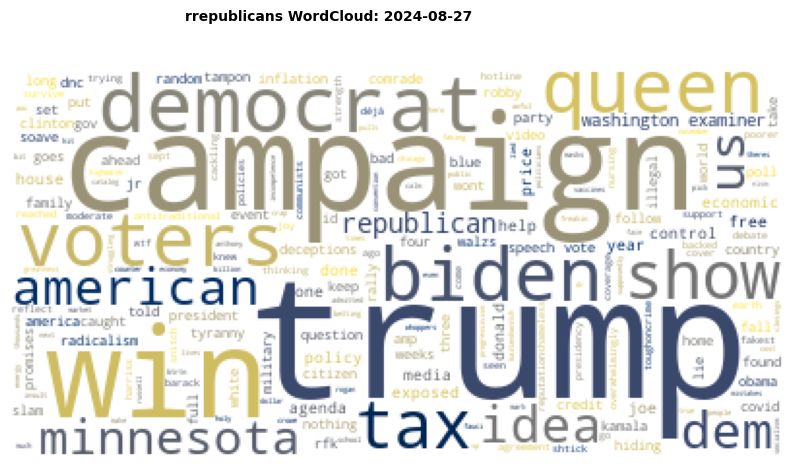

In [39]:
wc(df)